In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import batch_norm
import csv
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

## Data reading and preprocessing

In [3]:
def data_preprop(X_filename, Y_filename):
    # reading CSV file
    reader = csv.reader(open(X_filename, 'r'), delimiter=',')
    data_full = np.array(list(reader))
    reader = csv.reader(open(Y_filename, 'r'), delimiter=',')
    activity_full = np.array(list(reader))
    # feature names
    feature_names = data_full[0, 1:]

    # names of the proteins
    protein_names = data_full[1:, 0]
    protein_names1 = activity_full[1:, 0]

    # names of receptors
    receptor_names = activity_full[0, 1:]

    # Object-Feature matrix (proteins description)
    X = data_full[1:, 1:].astype('double')

    # Activity matrix
    Y = activity_full[1:, 1:].astype('int16')

    X = X[np.argsort(protein_names), :]
    Y = Y[np.argsort(protein_names1), :]
    X = X[:, np.argsort(feature_names)]
    Y = Y[:, np.argsort(receptor_names)]

    return X, Y, receptor_names[np.argsort(receptor_names)], protein_names[np.argsort(protein_names)], feature_names[np.argsort(feature_names)]

In [201]:
X_test = []
Y_test = []

In [202]:
X_tmp, Y_tmp, receptor_names, protein_names, feature_names = data_preprop('features_2.csv', 'all_endpoints_with_missing_values_012615.csv')
X_test.append(X_tmp)
Y_test.append(Y_tmp)

In [203]:
X_tmp, Y_tmp, _, _, _ = data_preprop('features2.txt', 'test_set_1_012615.csv')
X_test.append(X_tmp)
Y_test.append(Y_tmp)

In [204]:
X_tmp, Y_tmp, _, _, _ = data_preprop('features3.txt', 'test_set_2_150724_edited.csv')
X_test.append(X_tmp)
Y_test.append(Y_tmp)

In [205]:
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

In [206]:
ind = np.random.permutation(X_test.shape[0])

In [207]:
X_test = X_test[ind, :]
Y_test = Y_test[ind, :]

In [208]:
print X_test.shape[0]

9437


In [209]:
ind = np.var(X_test, axis = 0) != 0
X_test = X_test[:, ind]
feature_names = feature_names[ind]

In [210]:
print Y.shape

(8513, 12)


In [197]:
print X_test.shape

(924, 165)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=15)

# Building the model

In [14]:
input_shape = (None, X.shape[1])

In [15]:
target = T.matrix()
input_X = T.matrix()

In [16]:
from dnn_class import DNN

In [17]:
model = DNN(input_X, target, X_train, Y_train, X_test, Y_test)

In [18]:
l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X)

## Autoencoder

In [19]:
HU_enc = 256
HU_dec = 256
dimZ = 128
n_out = X.shape[1]

In [20]:
l_z, l_ae_out = model.build_ae(l_input=l_input, HU_enc=HU_enc, HU_dec=HU_dec, dimZ=dimZ, n_out=n_out)

In [21]:
ae_train, ae_test, ae_pred = model.build_ae_loss(l_ae_out)

In [22]:
ae_train_loss_log = []
ae_val_loss_log = []

In [44]:
ae_train_loss_log, ae_val_loss_log = model.fit_ae(train_fn=ae_train, test_fn=ae_test, train_loss_log=ae_train_loss_log,
                                                 val_loss_log=ae_val_loss_log, num_epochs=100)

32658.6871835
Epoch 1 of 100 took 0.389s
  training loss (in-iteration):		30.750186
  validation loss:		19.83
Epoch 2 of 100 took 0.371s
  training loss (in-iteration):		25.223427
  validation loss:		12.99
Epoch 3 of 100 took 0.369s
  training loss (in-iteration):		14.615837
  validation loss:		5.75
Epoch 4 of 100 took 0.379s
  training loss (in-iteration):		6.197986
  validation loss:		2.22
Epoch 5 of 100 took 0.364s
  training loss (in-iteration):		2.631725
  validation loss:		1.00
Epoch 6 of 100 took 0.369s
  training loss (in-iteration):		1.236923
  validation loss:		0.57
Epoch 7 of 100 took 0.415s
  training loss (in-iteration):		0.710986
  validation loss:		0.45
Epoch 8 of 100 took 0.404s
  training loss (in-iteration):		0.539951
  validation loss:		0.40
Epoch 9 of 100 took 0.391s
  training loss (in-iteration):		0.456741
  validation loss:		0.38
Epoch 10 of 100 took 0.394s
  training loss (in-iteration):		0.407043
  validation loss:		0.35
392.572276688
Epoch 11 of 100 took 0.425

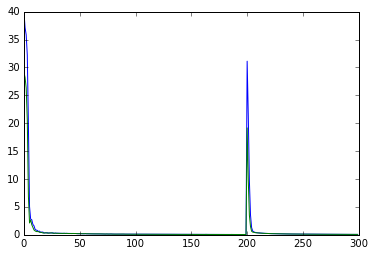

In [37]:
plt.plot(ae_train_loss_log, label='Train error')
plt.plot(ae_val_loss_log, label='Validation error')

## Whole network

In [ ]:
lasagne.layers.DropoutLayer()

In [45]:
l_nn_out = model.build_nn(l_z)

In [28]:
nn_train, nn_test, nn_pred = model.build_nn_loss(l_nn_out, learning_rate=0.9)

In [29]:
train_loss_log = []
val_loss_log = []
scores = []

In [46]:
for _ in xrange(100):
    train_loss_log, val_loss_log = model.fit_nn(train_fn=nn_train, test_fn=nn_test, 
                                                train_loss_log=train_loss_log, val_loss_log=val_loss_log, num_epochs=1)
    Y_pred = nn_pred(X_test)
    for i in range(Y_test.shape[1]):
        ind = np.where(Y_test[:, i] != 999)
        fpr, tpr, _ = roc_curve(Y_test[ind, i][0], Y_pred[ind, i][0])
        scores.append(roc_auc_score(Y_test[ind, i][0], Y_pred[ind, i][0]))

17377.4812731
Epoch 1 of 1 took 0.249s
  training loss (in-iteration):		1.578620
  validation loss:		1.90
9936.411391
Epoch 1 of 1 took 0.243s
  training loss (in-iteration):		1.084183
  validation loss:		1.98
7214.90138965
Epoch 1 of 1 took 0.261s
  training loss (in-iteration):		1.001228
  validation loss:		2.04
6485.47492657
Epoch 1 of 1 took 0.245s
  training loss (in-iteration):		0.924203
  validation loss:		2.04
6164.68497265
Epoch 1 of 1 took 0.278s
  training loss (in-iteration):		0.880000
  validation loss:		2.06
6007.80876835
Epoch 1 of 1 took 0.254s
  training loss (in-iteration):		0.849437
  validation loss:		2.05
5895.38682337
Epoch 1 of 1 took 0.259s
  training loss (in-iteration):		0.903522
  validation loss:		2.05
5991.04519598
Epoch 1 of 1 took 0.262s
  training loss (in-iteration):		0.935860
  validation loss:		2.04
5823.86337298
Epoch 1 of 1 took 0.249s
  training loss (in-iteration):		0.886553
  validation loss:		2.04
5756.03704043
Epoch 1 of 1 took 0.251s
  trainin

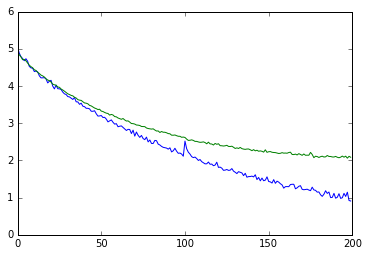

In [39]:
plt.plot(train_loss_log)
plt.plot(val_loss_log)

In [40]:
print len(scores)

2400


In [41]:
score = np.reshape(np.array(scores), (300, 12))

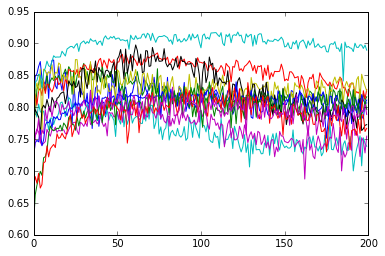

In [42]:
plt.plot(score)

In [43]:
print receptor_names 
print np.max(score, axis = 0) 
print np.argmax(score, axis = 0)
print score[np.argmax(score, axis = 0), :]

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.87408281  0.86894992  0.88520639  0.81509912  0.80310858  0.87474134
  0.89770608  0.83629769  0.83989451  0.83988167  0.91796576  0.83157239]
[ 12  34  74  21  52  25  61 121 105 117 122  83]
[[ 0.87408281  0.84198758  0.83095137  0.77289377  0.76298459  0.84347413
   0.80929407  0.78524201  0.76351916  0.7417324   0.88074651  0.80166061]
 [ 0.82674453  0.86894992  0.8684125   0.79339043  0.77292125  0.87160892
   0.8584579   0.81103531  0.7836935   0.79153106  0.90748786  0.82629995]
 [ 0.82593965  0.86042719  0.88520639  0.79974682  0.79037779  0.83143806
   0.8805091   0.81751759  0.82966816  0.79325491  0.90855979  0.80361183]
 [ 0.80557427  0.86363636  0.85942889  0.81509912  0.76501505  0.83307072
   0.84140891  0.79677429  0.78391327  0.77680246  0.89321209  0.80919564]
 [ 0.79793726  0.82494213  0.8805909   0.77356712  0.80310858  0.8361272
   0

In [43]:
print receptor_names 
print np.max(score, axis = 0) 
print np.argmax(score, axis = 0)
print score[np.argmax(score, axis = 0), :]

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.812496    0.90352349  0.87701239  0.82927506  0.77951574  0.86623892
  0.82875972  0.83034864  0.85362316  0.79257734  0.91862656  0.85199364]
[  7  33 258  10 175 142 260 202 261 136 267 153]
[[ 0.812496    0.77735408  0.82427432  0.79906348  0.72928006  0.28708544
   0.70375972  0.74571212  0.70584722  0.6955348   0.8323379   0.80524706]
 [ 0.791552    0.90352349  0.85154303  0.8039889   0.72141013  0.8434588
   0.73861279  0.78997814  0.78622737  0.74592573  0.87690168  0.82292074]
 [ 0.783008    0.86615314  0.87701239  0.78716615  0.75803126  0.83373835
   0.81957649  0.81829774  0.83325087  0.77618029  0.91636761  0.82950098]
 [ 0.791328    0.83709579  0.84738754  0.82927506  0.73945065  0.31395654
   0.71495246  0.75925537  0.70681977  0.72117019  0.84715404  0.81393102]
 [ 0.7704      0.86650905  0.86449839  0.81616372  0.77951574  0.8452945
   0.

In [63]:
print receptor_names 
print np.max(score, axis = 0) 
print np.argmax(score, axis = 0)
print score[np.argmax(score, axis = 0), :]

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.83248618  0.91438457  0.89488128  0.8378541   0.83491072  0.80198413
  0.86353189  0.82380641  0.84657375  0.81664925  0.88643991  0.84362099]
[188  46 253  24 141  70 384 423 236 255 361 416]
[[ 0.83248618  0.89326906  0.87784599  0.80632724  0.8250924   0.77065581
   0.7860671   0.80418096  0.82450639  0.79615577  0.87225372  0.83205017]
 [ 0.77309613  0.91438457  0.88256221  0.81081155  0.79719923  0.78617377
   0.76970853  0.78768577  0.75946574  0.75978855  0.84751248  0.78671532]
 [ 0.79133226  0.88200154  0.89488128  0.79812425  0.83264095  0.75367586
   0.82387031  0.81119685  0.83456114  0.811151    0.87981217  0.82910446]
 [ 0.75994293  0.88123263  0.87893018  0.8378541   0.78325785  0.75983709
   0.72241784  0.75679133  0.69221835  0.72978295  0.8161576   0.7767624 ]
 [ 0.82633315  0.89255929  0.88504906  0.80807722  0.83491072  0.76167502
   

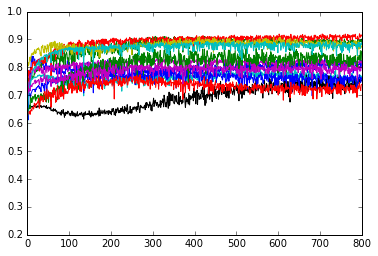

In [78]:
plt.plot(score)

In [79]:
print receptor_names 
print np.max(score, axis = 0) 
print np.argmax(score, axis = 0)
print score[np.argmax(score, axis = 0), :]

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.84020392  0.91132507  0.92049571  0.79837499  0.83260163  0.91104031
  0.772954    0.79677248  0.86777334  0.77410305  0.89375838  0.81808132]
[ 13 306 794 521 571 412 667 340 547 270 493 322]
[[ 0.84020392  0.76106633  0.81766518  0.75863287  0.78895122  0.84666568
   0.66033898  0.72027521  0.6952913   0.65621872  0.78527755  0.74183147]
 [ 0.80269394  0.91132507  0.90631371  0.75607171  0.82012195  0.88719621
   0.6825908   0.76944863  0.84237829  0.75755922  0.88576026  0.81413012]
 [ 0.81025946  0.89516112  0.92049571  0.76971651  0.82825203  0.88947836
   0.75757869  0.77387017  0.83653631  0.74551148  0.88906543  0.80258363]
 [ 0.80909491  0.8982331   0.90820562  0.79837499  0.82460976  0.88752223
   0.73716707  0.78235326  0.83827614  0.73381251  0.88236122  0.79349384]
 [ 0.80881802  0.90114014  0.91421134  0.77923254  0.83260163  0.90512745
   

In [81]:
print receptor_names 
print np.max(score, axis = 0) 
print np.argmax(score, axis = 0)
print score[np.argmax(score, axis = 0), :]

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.94488189  0.94301471  0.88786092  0.87510201  0.82027235  0.86705139
  0.81548807  0.81359438  0.85547326  0.80131602  0.9261809   0.83023406]
[ 81 198 152  94  70 113 167  75 165  59 197  80]
[[ 0.94488189  0.90463936  0.87860217  0.85357726  0.81596488  0.84347348
   0.79141717  0.80685975  0.82107947  0.76084848  0.90350757  0.81772391]
 [ 0.9265555   0.94301471  0.87788244  0.81974293  0.78055287  0.83862325
   0.79260527  0.79311081  0.82387226  0.73703896  0.91953189  0.80058799]
 [ 0.8941794   0.91542367  0.88786092  0.82276931  0.78748262  0.84807639
   0.78956373  0.79253671  0.83402647  0.71335065  0.92321271  0.80822566]
 [ 0.93546395  0.91931022  0.88095005  0.87510201  0.80122121  0.85346249
   0.78875582  0.80033857  0.82865339  0.75277922  0.90778987  0.81290283]
 [ 0.93061603  0.89466036  0.88084524  0.85017682  0.82027235  0.85026106
   

# Evaluating results

In [198]:
Y_pred = nn_pred(X_test)

In [199]:
print Y_pred[99,:]
print Y_test[99,:]

[ 0.10565061  0.09092465  0.08561691  0.05906787  0.19737617  0.12739871
  0.08851941  0.04361931  0.10755444  0.06461294  0.05143892  0.06365821]
[0 0 0 0 0 0 0 0 0 0 0 0]


NR-AR 0.540094339623
NR-AR-LBD 0.651261373036
NR-AhR 0.833827286663
NR-Aromatase 0.727867080913
NR-ER 0.67086391869
NR-ER-LBD 0.711547619048
NR-PPAR-gamma 0.583305274972
SR-ARE 0.693584993052
SR-ATAD5 0.607583224379
SR-HSE 0.716351118761
SR-MMP 0.827189048855
SR-p53 0.566038602941


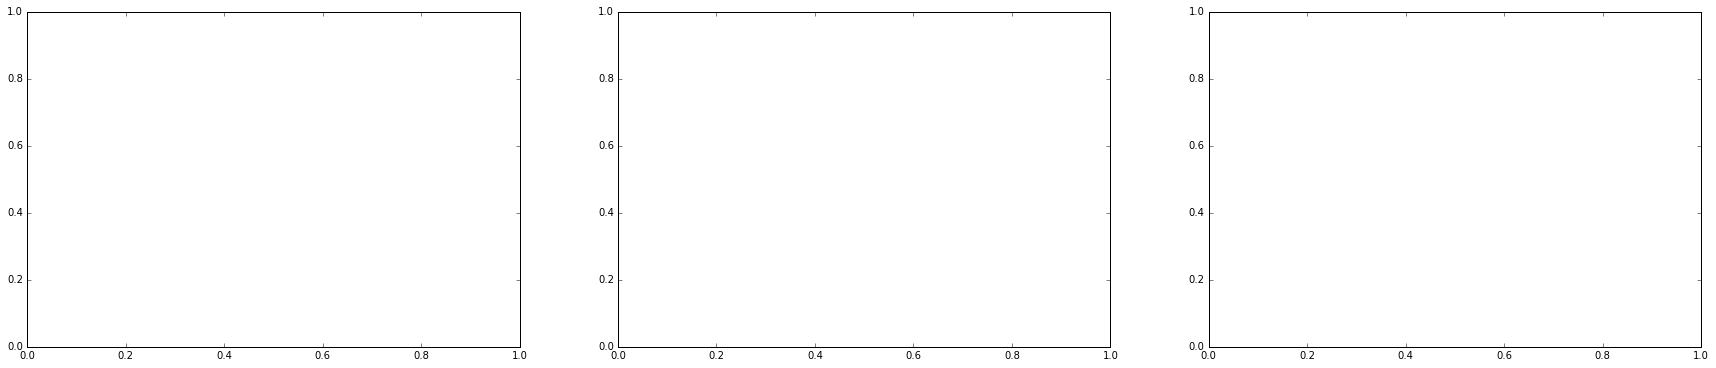

In [200]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
for i in range(Y_test.shape[1]):
    ind = np.where(Y_test[:, i] != 999)
    fpr, tpr, _ = roc_curve(Y_test[ind, i][0], Y_pred[ind, i][0])
    print receptor_names[i], roc_auc_score(Y_test[ind, i][0], Y_pred[ind, i][0])
    #ax[i].plot(fpr, tpr, lw=2, label='NN')
    #ax[i].legend(loc='lower right')

In [224]:
k = 5
y = Y
score = []
n = X.shape[0]
start_ind = 0
step = int(n / k)
end_ind = step
input_shape = (None, X.shape[1])
l_input = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X)
for j in xrange(k):
    score_cur = np.zeros(y.shape[1])
    test_ind = np.arange(start_ind,end_ind)
    train_ind = np.concatenate((np.arange(0, start_ind), np.arange(end_ind, n)))
    X_train = X[train_ind, :]
    y_train = y[train_ind, :]
    X_test = X[test_ind, :]
    y_test = y[test_ind, :]
    model = DNN(input_X, target, X_train, y_train, X_test, y_test)
    #l_z, l_ae_out = model.build_ae(l_input=l_input, HU_enc=HU_enc, HU_dec=HU_dec, dimZ=dimZ, n_out=X.shape[1])
    #ae_train, ae_test, ae_pred = model.build_ae_loss(l_ae_out)
    #ae_train_loss_log, ae_val_loss_log = model.fit_ae(ae_train, ae_test, num_epochs=200, batch_size=1000)
    l_nn_out = model.build_nn(l_input)#l_z)
    nn_train, nn_test, nn_pred = model.build_nn_loss(l_nn_out, learning_rate=0.9)
    nn_train_loss_log, nn_val_loss_log = model.fit_nn(nn_train, nn_test, num_epochs=220, batch_size=1000)
    y_pred = nn_pred(X_test)
    for i in range(y.shape[1]):
        ind = np.where(y_test[:, i] != 999)
        fpr, tpr, _ = roc_curve(y_test[ind, i][0], y_pred[ind, i][0])
        score_cur[i] =  roc_auc_score(y_test[ind, i][0], y_pred[ind, i][0])
    score.append(score_cur)
    start_ind = end_ind
    end_ind = end_ind + step
    if end_ind > n:
        end_ind = n

Epoch 1 of 220 took 0.084s
  training loss (in-iteration):		5.247316
  validation loss:		4.38
Epoch 2 of 220 took 0.076s
  training loss (in-iteration):		4.797203
  validation loss:		4.15
Epoch 3 of 220 took 0.075s
  training loss (in-iteration):		4.566295
  validation loss:		4.03
Epoch 4 of 220 took 0.078s
  training loss (in-iteration):		4.425128
  validation loss:		3.93
Epoch 5 of 220 took 0.096s
  training loss (in-iteration):		4.335952
  validation loss:		3.87
Epoch 6 of 220 took 0.080s
  training loss (in-iteration):		4.243492
  validation loss:		3.77
Epoch 7 of 220 took 0.083s
  training loss (in-iteration):		4.143920
  validation loss:		3.69
Epoch 8 of 220 took 0.083s
  training loss (in-iteration):		4.066857
  validation loss:		3.64
Epoch 9 of 220 took 0.077s
  training loss (in-iteration):		3.972731
  validation loss:		3.56
Epoch 10 of 220 took 0.088s
  training loss (in-iteration):		3.899562
  validation loss:		3.50
Epoch 11 of 220 took 0.082s
  training loss (in-iteration):

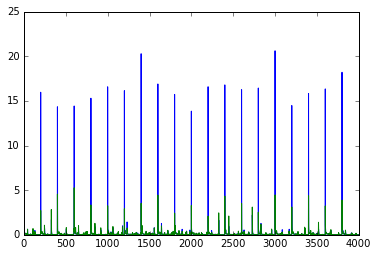

In [163]:
plt.plot(ae_train_loss_log)
plt.plot(ae_val_loss_log)

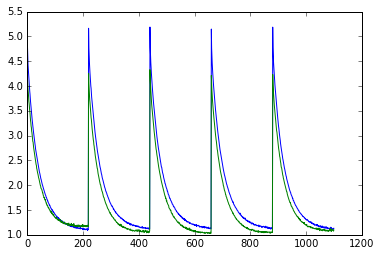

In [226]:
plt.plot(nn_train_loss_log[-1100:])
plt.plot(nn_val_loss_log[-1100:])

In [227]:
# nn training 220 epochs learning_rate = 0.9 batch_size=1000 + Dropout training dataset without AE
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.86953071  0.90160075  0.90020315  0.85392749  0.80950116  0.85905227
  0.85667776  0.81610442  0.83199256  0.82090954  0.8923199   0.83677706]


In [228]:
print np.concatenate(score).reshape(k, 12).std(axis=0)

[ 0.03099293  0.0254801   0.01075021  0.04021835  0.03546144  0.02887597
  0.02402066  0.01301059  0.03014335  0.03630874  0.01375884  0.02049565]


In [222]:
# nn training 200 epochs learning_rate = 0.9 batch_size=1000 + Dropout training dataset without AE
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.87068438  0.91570057  0.89772866  0.85847043  0.80464994  0.85577689
  0.86018042  0.820201    0.83870378  0.82567656  0.89160762  0.84210853]


In [223]:
print np.concatenate(score).reshape(k, 12).std(axis=0)

[ 0.02900656  0.01446193  0.01404567  0.04676627  0.03460986  0.02476363
  0.02880455  0.01153568  0.02029545  0.02846325  0.0112261   0.01401691]


In [219]:
# nn training 150 epochs learning_rate = 0.9 batch_size=1000 + Dropout training dataset without AE
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.8636278   0.90339778  0.89504512  0.8640713   0.80175651  0.84792718
  0.83753494  0.80935967  0.82660896  0.80979816  0.88693773  0.83053867]


In [216]:
# nn training 130 epochs learning_rate = 0.9 batch_size=1000 + Dropout training dataset without AE
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.86516691  0.90861804  0.89145878  0.85351253  0.79978538  0.84405781
  0.83690813  0.80696934  0.83049858  0.80757925  0.88279966  0.82809377]


In [153]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1000 + Dropout
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.83703581  0.9152079   0.88601909  0.83893225  0.78931138  0.85525147
  0.82457676  0.81139405  0.84012444  0.79550447  0.90791461  0.83230555]


In [213]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1000 + Dropout training dataset without AE
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.87462599  0.89596021  0.88407121  0.85324433  0.79752312  0.84796722
  0.81507091  0.79178215  0.80138718  0.79151408  0.87662536  0.81355721]


In [167]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1000 + Dropout training dataset
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.85102919  0.92737596  0.8876233   0.8343021   0.79018184  0.87941438
  0.8190472   0.81279547  0.8238491   0.79819615  0.9036068   0.82157536]


In [154]:
print np.concatenate(score).reshape(k, 12).std(axis=0)

[ 0.05268932  0.00882914  0.02448524  0.0274957   0.01513653  0.02168842
  0.02977837  0.018434    0.01841829  0.02777371  0.02274042  0.01227818]


In [131]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1000 + Dropout
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.84518694  0.90354037  0.89469477  0.84462808  0.79665199  0.87352588
  0.81837713  0.82666847  0.84284203  0.80317784  0.90786948  0.84220141]


In [148]:
# nn training 100 epochs learning_rate = 0.9 batch_size=700 + Dropout
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.83565061  0.89161145  0.88436898  0.81956398  0.78298847  0.86535874
  0.81257925  0.81520452  0.83513207  0.79605056  0.90897787  0.8225995 ]


In [144]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1024 + Dropout
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.84679478  0.8980354   0.88308412  0.82778917  0.78226066  0.85451022
  0.83041309  0.80337948  0.83077171  0.79421221  0.9142426   0.83339232]


scores = model.cross_val(X, Y, nn_train, nn_test, ae_train, ae_test, nn_pred, k=2)

In [140]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1000 + Dropout + adamax training
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.85162529  0.90913731  0.88020643  0.8260654   0.78442611  0.88064303
  0.78583365  0.81526978  0.83225942  0.80579732  0.90828562  0.82130988]


In [136]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1000 + Dropout + adam training
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.84219333  0.88891283  0.88145815  0.83110027  0.79300138  0.86045075
  0.79177637  0.79981872  0.81749692  0.77771706  0.89285423  0.81858416]


In [67]:
# nn training 100 epochs learning_rate = 0.9
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.84279311  0.90208356  0.89290969  0.81994371  0.79305954  0.8531954
  0.82923574  0.81302911  0.84369567  0.80192078  0.9129823   0.82326059]


In [124]:
# nn training 130 epochs learning_rate = 0.9 batch_size=1500 
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.819769    0.89807785  0.86831519  0.75441058  0.75388474  0.81537956
  0.79032254  0.7730857   0.78771429  0.71208996  0.89325503  0.7612231 ]


In [120]:
# nn training 130 epochs learning_rate = 0.9 batch_size=1500 
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.81781821  0.90298162  0.86867373  0.82131456  0.79052313  0.87038066
  0.8296214   0.7984228   0.82625608  0.7931178   0.90741371  0.79383784]


In [109]:
# nn training 200 epochs learning_rate = 0.9 batch_size=1500 
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.80706028  0.88977564  0.85063556  0.77800968  0.75598882  0.84115943
  0.76621726  0.78251482  0.77315239  0.78606085  0.89592575  0.78399381]


In [104]:
# nn training 100 epochs learning_rate = 0.9 batch_size=1500
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.82048806  0.88943588  0.89764367  0.82727197  0.79887636  0.8596576
  0.83479235  0.81152992  0.83859839  0.79242591  0.89499004  0.81374217]


In [99]:
# nn training 100 epochs learning_rate = 0.7 batch_size=1500
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.83088216  0.90468484  0.88792156  0.82579838  0.80286879  0.85986864
  0.84374633  0.80933631  0.84128251  0.78218653  0.89544962  0.81379069]


In [97]:
# nn training 100 epochs learning_rate = 0.7 batch_size=100
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.79876691  0.86265812  0.86950877  0.73835809  0.75363271  0.80124627
  0.7771571   0.78339891  0.77084848  0.75497874  0.88863053  0.76973337]


In [93]:
# nn training 100 epochs learning_rate = 0.7 full gradient learning
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.83936838  0.85726583  0.86176175  0.81949881  0.7809152   0.82177492
  0.73466854  0.76893584  0.75861858  0.71971002  0.86377527  0.77340386]


In [89]:
# nn training 100 epochs learning_rate = 0.7
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.82695817  0.8934446   0.88560754  0.82763647  0.80154481  0.85575104
  0.81871218  0.8165997   0.82263532  0.78945377  0.90610022  0.82133104]


In [84]:
# nn training 100 epochs learning_rate = 1.0
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.81238367  0.89645014  0.89234557  0.82156954  0.79197037  0.84182302
  0.82477895  0.81034413  0.84478899  0.77569717  0.90631692  0.80940163]


In [80]:
# nn training 130 epochs learning_rate = 0.9
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.82288422  0.90172734  0.88884527  0.80882062  0.77586758  0.82562379
  0.83325786  0.80675179  0.83110396  0.76772663  0.90942777  0.81277057]


In [76]:
# nn training 80 epochs learning_rate = 0.9
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.82148502  0.8985514   0.88839858  0.83548788  0.79701144  0.8486088
  0.82518582  0.81919649  0.82983865  0.76408606  0.90766063  0.82966115]


In [72]:
# nn training 50 epochs learning_rate = 0.9
print receptor_names
print np.concatenate(score).reshape(k, 12).mean(axis=0)

['NR-AR' 'NR-AR-LBD' 'NR-AhR' 'NR-Aromatase' 'NR-ER' 'NR-ER-LBD'
 'NR-PPAR-gamma' 'SR-ARE' 'SR-ATAD5' 'SR-HSE' 'SR-MMP' 'SR-p53']
[ 0.84487536  0.89964521  0.88906601  0.85220246  0.79079851  0.85792184
  0.81893683  0.81953211  0.83055449  0.79954576  0.89594254  0.81503311]


In [62]:
print np.concatenate(score).reshape(k, 12).mean(axis=0)

[ 0.84413911  0.89006824  0.88150391  0.82144761  0.78189412  0.82863137
  0.82144445  0.81943607  0.81360076  0.79415921  0.8997149   0.81410432]


In [49]:
print np.concatenate(score).reshape(k, 12).mean(axis=0)

[ 0.83492957  0.89009362  0.88167622  0.82925638  0.79512983  0.84317272
  0.78127753  0.80375417  0.80645902  0.76365098  0.89118801  0.80274714]


In [68]:
print np.concatenate(score).reshape(k, 12).std(axis=0)

[ 0.04533623  0.02253478  0.01295715  0.02745194  0.03486713  0.02502491
  0.04199225  0.01030281  0.01984736  0.01512168  0.01400416  0.01206108]


In [31]:
from dnn_class import Evaluator

In [32]:
eval = Evaluator(input_X, target)

33324.1897148
Epoch 1 of 500 took 0.200s
  training loss (in-iteration):		32.747477
  validation loss:		50.15
Epoch 2 of 500 took 0.134s
  training loss (in-iteration):		32.976947
  validation loss:		49.64
Epoch 3 of 500 took 0.138s
  training loss (in-iteration):		32.369834
  validation loss:		49.13
Epoch 4 of 500 took 0.148s
  training loss (in-iteration):		32.462725
  validation loss:		49.25
Epoch 5 of 500 took 0.144s
  training loss (in-iteration):		31.932597
  validation loss:		48.57
Epoch 6 of 500 took 0.157s
  training loss (in-iteration):		31.418075
  validation loss:		47.65
Epoch 7 of 500 took 0.135s
  training loss (in-iteration):		31.293243
  validation loss:		45.94
Epoch 8 of 500 took 0.135s
  training loss (in-iteration):		28.947927
  validation loss:		38.50
Epoch 9 of 500 took 0.173s
  training loss (in-iteration):		19.869695
  validation loss:		17.98
Epoch 10 of 500 took 0.186s
  training loss (in-iteration):		6.567739
  validation loss:		4.72
3382.94414157
Epoch 11 of 5

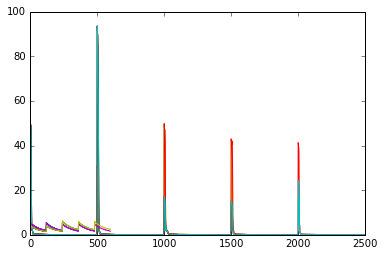

In [33]:
scores = eval.cross_val(X, Y)